In [1]:
import numpy as np
from matplotlib import pyplot as plt
import simple_GP_temperature.helper_sklearn as helper
from simple_GP_temperature.bell_curve import Bellcurve
from simple_GP_temperature.non_convex_function import NonConvexFunction
from simple_GP_temperature.random_initial_2d import RandomInit2D
from simple_GP_temperature.BO_GP_temperature import BOTemperatureGP
from simple_GP_temperature.fullfactor_initial import FullFactorInitial2D
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
objective = NonConvexFunction()

In [3]:
def find_stable_point(data_dict, start_index, threshold):
     # Convert the dictionary to a list of items, sorted by the keys
     data_list = sorted(list(data_dict.items()))
     # Start from the given index
     for i in range(start_index, len(data_list)-1):
         # Calculate the difference between the current and next value
         if i+3 <= len(data_list)-1:
             difference = abs(((data_list[i][1]-data_list[i+1][1])+(data_list[i+1][1] - data_list[i+2][1])+(data_list[i+2][1]-data_list[i+3][1]))/3)
         else:
             difference = threshold+1
         # If the difference is below the threshold, return the current index
         if difference < threshold:
             return i

     # If no stable point was found, return None
     return None

In [4]:
def imporvement_curve(data_dict, start_index):
    #convert the dictionary to a list of items, sorted by the keys 
    data_list = sorted(list(data_dict.items()))
    result_curve = []
    result_curve.append(data_list[start_index][1])
    for i in range(start_index,len(data_list)-1):
        if abs(data_list[i][1])<abs(result_curve[-1]):
            result_curve.append(data_list[i][1])
        else: result_curve.append(result_curve[-1])
    return result_curve

# random initial around local optimal

In [5]:
from simple_GP_temperature.local_optima_initial_non_convex_2d import LocalOptimaInit2DNonConvex
local_optima_init=LocalOptimaInit2DNonConvex()
bayes_opt_local_opt = BOTemperatureGP(evaluation_component=objective, initial_method=local_optima_init, 
                                      lower_bound=[-10,-10], upper_bound=[10,10], total_iter=50)
local_opt_mappings_lst=[]
for i in tqdm(range(50)):
    local_opt_mappings_lst.append(bayes_opt_local_opt.optimise())

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


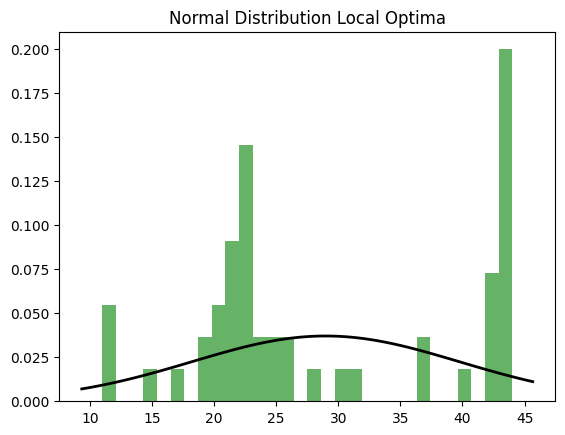

In [6]:
threshold = 0.1
converge_iter_num_lst_random = []
for local_opt_mappings in local_opt_mappings_lst:
    converge_iter_num_lst_random.append(find_stable_point(local_opt_mappings, 8, threshold))

numbers = converge_iter_num_lst_random
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

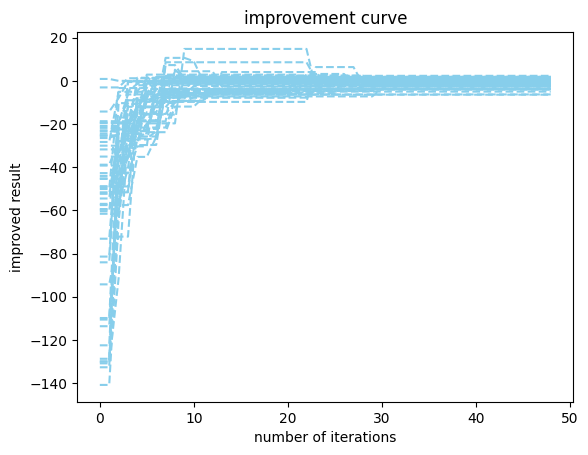

In [9]:
impro_iter_num_lst_random = []
for local_opt_mappings in local_opt_mappings_lst:
    impro_iter_num_lst_random.append(imporvement_curve(local_opt_mappings, start_index = 9))

x_value=range(len(impro_iter_num_lst_random[0]))
for i, y_values in enumerate(impro_iter_num_lst_random):
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.show()

# Full Factorial design around local optimal

In [11]:
initial_sample_lst = [[6.27,6.27],
                      [6.28,6.27],
                      [6.29,6.27],
                      [6.27,6.28],
                      [6.28,6.28],
                      [6.29,6.28],
                      [6.27,6.29],
                      [6.28,6.29],
                      [6.29,6.29]]
initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_fullfactor = BOTemperatureGP(evaluation_component=objective, 
                                       initial_method=initial_method, 
                                       initial_sample_size= 9, lower_bound=[-10,-10], upper_bound=[10,10], 
                                       total_iter=50)

In [12]:
fullfactor_mappings_lst=[]
for i in tqdm(range(50)):
    fullfactor_mappings_lst.append(bayes_opt_fullfactor.optimise())

100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


In [13]:
threshold = 0.1
converge_iter_num_lst_fullfactor = []
for fullfactor_mappings in fullfactor_mappings_lst:
    converge_iter_num_lst_fullfactor.append(find_stable_point(fullfactor_mappings, start_index = 9, threshold = 0.1))

none_replacement = max([x for x in converge_iter_num_lst_fullfactor if x is not None]) * 2 
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst_fullfactor]

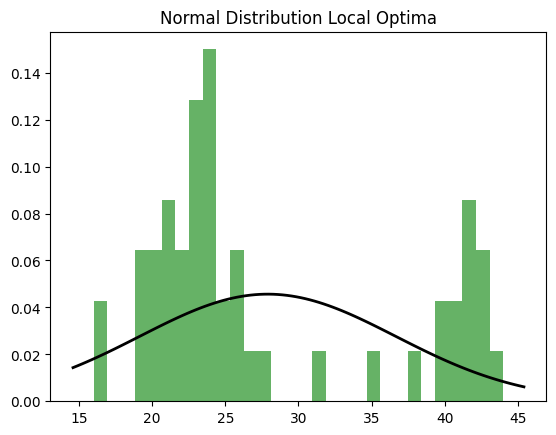

In [14]:
import seaborn as sns
import numpy as np
from scipy.stats import norm
numbers_1 = replaced_list
plt.hist(numbers_1, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers_1)), 2) / (2 * np.std(numbers_1) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers_1))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

In [15]:
impro_iter_num_lst_1 = []
for fullfactor_mappings in fullfactor_mappings_lst:
    impro_iter_num_lst_1.append(imporvement_curve(fullfactor_mappings, start_index = 9))


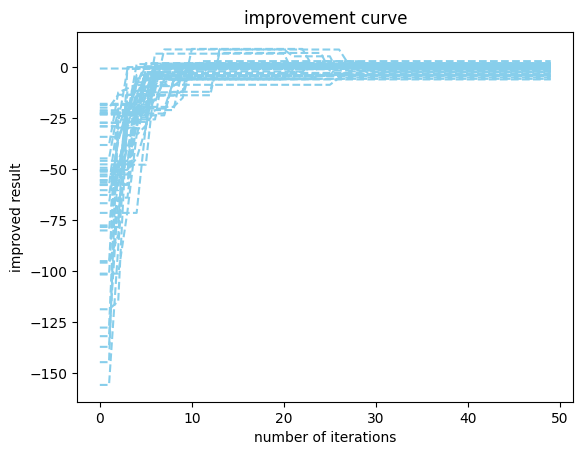

In [16]:
x_value=range(len(impro_iter_num_lst_1[0]))
for i, y_values in enumerate(impro_iter_num_lst_1):
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.show()


# D-optimal design around local optimal with 7 samples 

In [17]:
initial_sample_lst = [[6.27,6.278],
                      [6.270,6.282],
                      [6.278,6.290],
                      [6.280,6.280],
                      [6.282,6.270],
                      [6.282,6.290],
                      [6.290,6.278]]
initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_doptimal_7 = BOTemperatureGP(evaluation_component=objective, 
                                       initial_method=initial_method, 
                                       initial_sample_size= 7, lower_bound=[-10,-10], upper_bound=[10,10], total_iter=50)

In [18]:
doptimal_mappings_lst_1=[]
for i in tqdm(range(50)):
    doptimal_mappings_lst_1.append(bayes_opt_doptimal_7.optimise())

100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


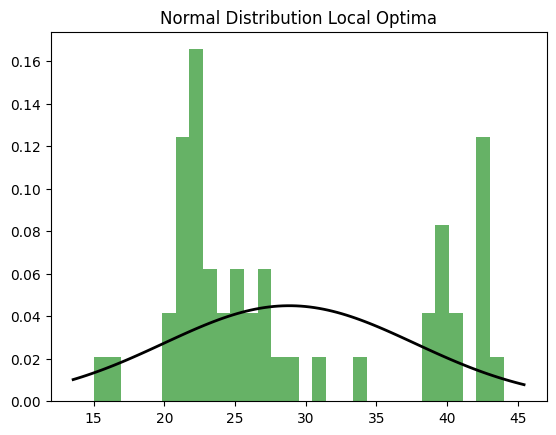

In [19]:
threshold = 0.1
converge_iter_num_lst_doptimal_7 = []
for doptimal_mappings in doptimal_mappings_lst_1:
    converge_iter_num_lst_doptimal_7.append(find_stable_point(doptimal_mappings, start_index = 7, threshold = 0.1))
numbers = converge_iter_num_lst_doptimal_7
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

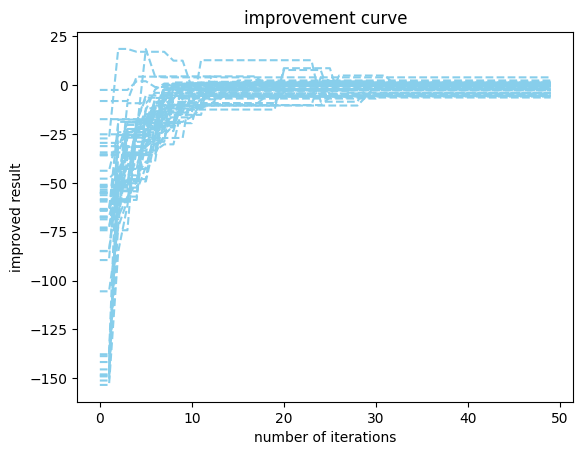

In [32]:
impro_iter_num_lst_2 = []
for doptimal_mappings in doptimal_mappings_lst_1:
    impro_iter_num_lst_2.append(imporvement_curve(doptimal_mappings, start_index = 7))

for i, y_values in enumerate(impro_iter_num_lst_2):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.show()

# D-optimal design around local optimal with 11 samples

In [21]:
initial_sample_lst = [
    [6.29,6.278],
    [6.290,6.282],
    [6.278,6.290],
    [6.278,6.270],
    [6.2784,6.290],
    [6.280,6.280],
    [6.280,6.2804],
    [6.282,6.290],
    [6.282,6.270],
    [6.270,6.2780],
    [6.270,6.2820]]

initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_doptimal_11 = BOTemperatureGP(evaluation_component=objective, initial_method=initial_method, initial_sample_size= 11, lower_bound=[-10,-10], upper_bound=[10,10], total_iter=50)
doptimal_mappings_lst_2=[]
for i in tqdm(range(50)):
    doptimal_mappings_lst_2.append(bayes_opt_doptimal_11.optimise())


100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


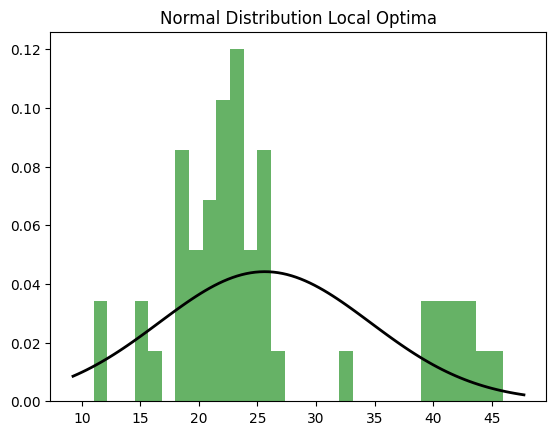

In [22]:
threshold = 0.1
converge_iter_num_lst_3 = []
for doptimal_mappings in doptimal_mappings_lst_2:
    converge_iter_num_lst_3.append(find_stable_point(doptimal_mappings, start_index = 11, threshold = 0.1))
numbers = converge_iter_num_lst_3
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

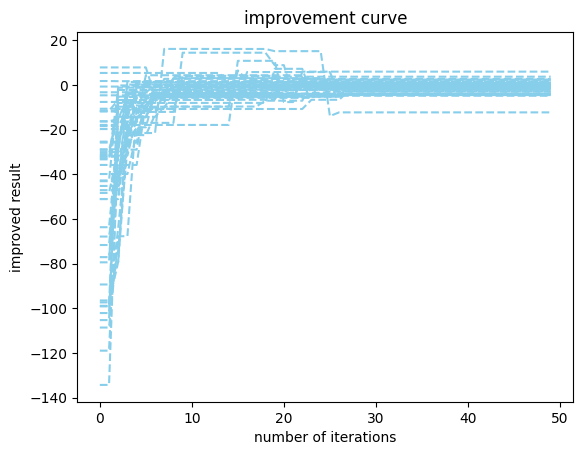

In [27]:
impro_iter_num_lst_3 = []
for doptimal_mappings in doptimal_mappings_lst_2:
    impro_iter_num_lst_3.append(imporvement_curve(doptimal_mappings, start_index = 11))

for i, y_values in enumerate(impro_iter_num_lst_3):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')
    

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.show()

# D-optimal design around local optimal with 13 samples

In [29]:
initial_sample_lst = [
    [6.2900,6.2780],
    [6.2900,6.2816],
    [6.2900,6.2820],
    [6.2780,6.2900],
    [6.2780,6.2700],
    [6.2784,6.2900],
    [6.2800,6.2800],
    [6.2800,6.2804],
    [6.2820,6.2900],
    [6.2820,6.2700],
    [6.2700,6.2780],
    [6.2700,6.2816],
    [6.2700,6.2820],]

initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_doptimal_13 = BOTemperatureGP(evaluation_component=objective, 
                                        initial_method=initial_method, initial_sample_size= 13, 
                                        lower_bound=[-10,-10], upper_bound=[10,10], total_iter=50)
doptimal_mappings_lst_3=[]
for i in tqdm(range(50)):
    doptimal_mappings_lst_3.append(bayes_opt_doptimal_13.optimise())

100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


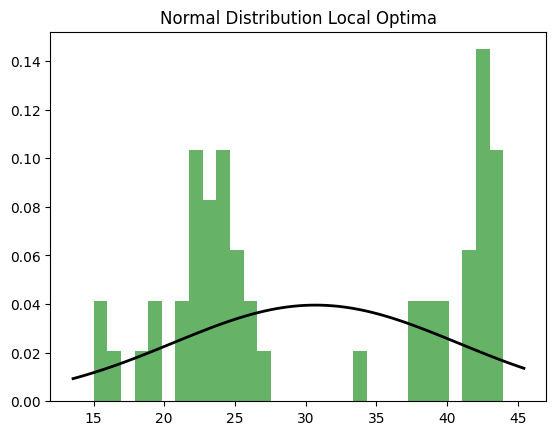

In [30]:
threshold = 0.1
converge_iter_num_lst_4 = []
for doptimal_mappings in doptimal_mappings_lst_3:
    converge_iter_num_lst_4.append(find_stable_point(doptimal_mappings, start_index = 13, threshold = 0.1))
numbers = converge_iter_num_lst_4
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

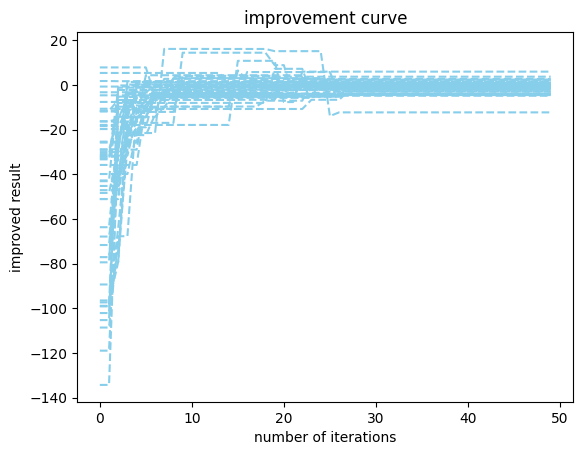

In [31]:
impro_iter_num_lst_4 = []
for doptimal_mappings in doptimal_mappings_lst_3:
    impro_iter_num_lst_4.append(imporvement_curve(doptimal_mappings, start_index = 13))

for i, y_values in enumerate(impro_iter_num_lst_3):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.show()

# D-optimal design around local optimal with 17 samples